In [2]:
import pandas as pd
import numpy as np
import yfinance as yf 
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import pandas_datareader.data as web

In [3]:
bnb_data = yf.download('BNB-USD', start='2017-01-01', end='2022-01-01')
# btc_df = pd.DataFrame(btc_data)

[*********************100%***********************]  1 of 1 completed


In [4]:
bnb_df = pd.DataFrame(bnb_data)

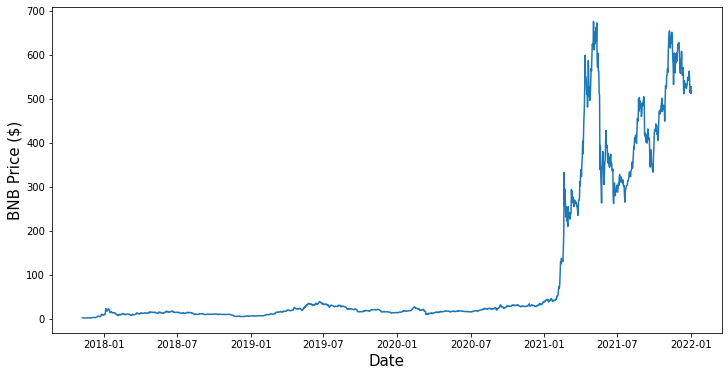

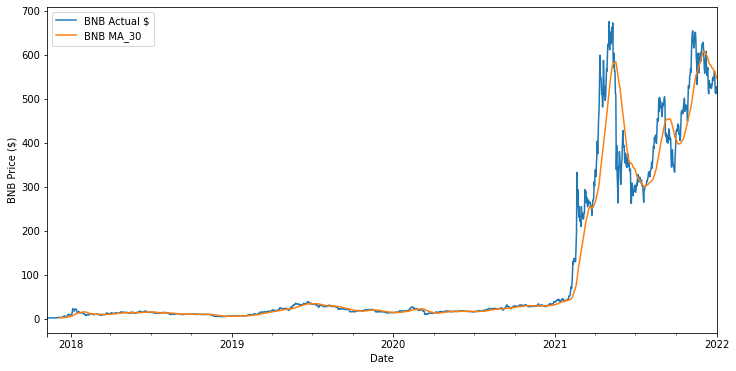

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(bnb_df["Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('BNB Price ($)',fontsize=15)
plt.show()


# Rolling mean
close_px = bnb_df['Close']
mavg = close_px.rolling(window=30).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='BNB Actual $')
mavg.plot(label='BNB MA_30')
plt.xlabel('Date')
plt.ylabel('BNB Price ($)')
plt.legend()

In [6]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = bnb_df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1510,738152.0,563.590332,563.590332,530.059937,534.928040,534.928040,2791585162
1511,738153.0,534.850037,540.615784,511.745331,514.000793,514.000793,2159325741
1512,738154.0,514.570251,527.568298,509.003479,518.909729,518.909729,1950603827
1513,738155.0,519.123047,527.697327,507.885712,511.708313,511.708313,2020489898
1514,738156.0,511.910370,527.352722,511.903534,527.352722,527.352722,1622547014


In [7]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()
prices = np.array(bnb_df['Close'])
prices = np.reshape(prices, (-1, 1))
# Fit the MinMaxScaler object with the features data X
scaler.fit(prices)
prices = scaler.transform(prices)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


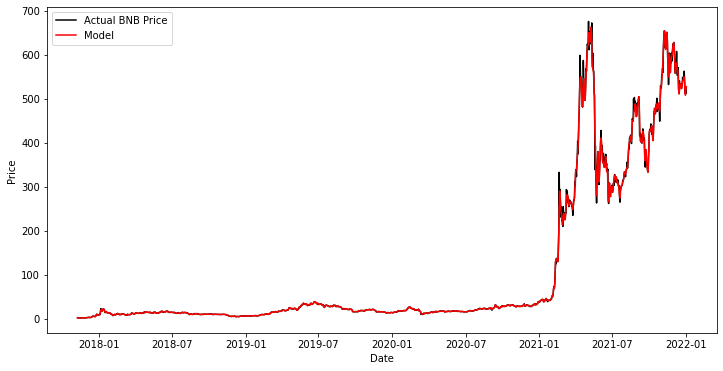

In [8]:
from sklearn.svm import SVR
from sklearn import svm
# import pandas_datareader.data as web
svr_model = svm.SVR()
#dates_df = pd.Series(dates_df['Date'])
#btc_df = pd.Series(btc_df['Close'])

##dates = dates_df['Date'].as_matrix()
#prices = btc_df['Close'].as_matrix()

# df = pd.DataFrame(columns=[dates_df['Date'],btc_df['Close']])

dates = np.array(dates_df['Date'])
prices = np.array(bnb_df['Close'])

# Convert to 1d Vector
dates = np.reshape(dates, (-1, 1)) #len(dates) as -1
prices = np.reshape(prices, (-1, 1)) #len(prices) as -1

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices) 




plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Actual BNB Price')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'Model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Create train set of adj close prices data:
#train_data = btc_df.loc[:,'Close'].as_matrix()
train_data = prices
print(train_data.shape) # 1258 


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1515, 1)


In [10]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1479, 36, 1)
X_train:
[[1.99076998]
 [1.79683995]
 [1.67047   ]
 [1.51969004]
 [1.68662   ]
 [1.59257996]
 [1.53044999]
 [1.57791996]
 [1.51036   ]
 [1.67433   ]
 [1.61377001]
 [1.62444997]
 [1.57405996]
 [1.61175001]
 [1.54869998]
 [1.71771002]
 [1.87387002]
 [1.85312998]
 [1.94298005]
 [1.91710997]
 [1.75153005]
 [1.99697006]
 [2.07023001]
 [2.08416009]
 [2.2272501 ]
 [2.49167991]
 [2.59529996]
 [2.58769011]
 [2.7799499 ]
 [2.83067012]
 [2.61043   ]
 [2.48337007]
 [2.70665002]
 [2.68475008]
 [2.77810001]
 [3.15874004]]


y_train: [[3.99615002]]



In [11]:
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
104/104 [==============================] - 11s 67ms/step - loss: 4.1483e-05 - val_loss: 0.0097
Epoch 2/20
104/104 [==============================] - 6s 56ms/step - loss: 1.6361e-05 - val_loss: 0.0060
Epoch 3/20
104/104 [==============================] - 6s 55ms/step - loss: 1.1931e-05 - val_loss: 0.0037
Epoch 4/20
104/104 [==============================] - 6s 55ms/step - loss: 1.1658e-05 - val_loss: 0.0039
Epoch 5/20
104/104 [==============================] - 6s 56ms/step - loss: 1.0023e-05 - val_loss: 0.0052
Epoch 6/20
104/104 [==============================] - 6s 56ms/step - loss: 1.0212e-05 - val_loss: 0.0039
Epoch 7/20
104/104 [==============================] - 6s 54ms/step - loss: 8.0158e-06 - val_loss: 0.0039
Epoch 8/20
104/104 [==============================] - 8s 77ms/step - loss: 9.5275e-06 - val_loss: 0.0028
Epoch 9/20
104/104 [==============================] - 6s 55ms/step - loss: 8.4763e-06 - val_loss: 0.0032
Epoch 10/20
104/104 [==============================] -

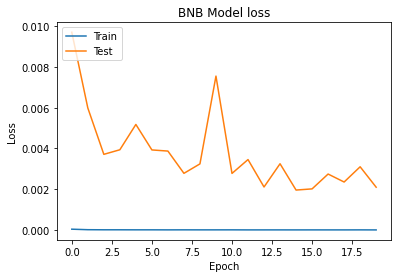

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BNB Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
model.evaluate(X_train, y_train)

47/47 [==============================] - 1s 23ms/step - loss: 6.3284e-04


0.0006328437011688948

In [13]:
predicted = model.predict(X_train)

In [14]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

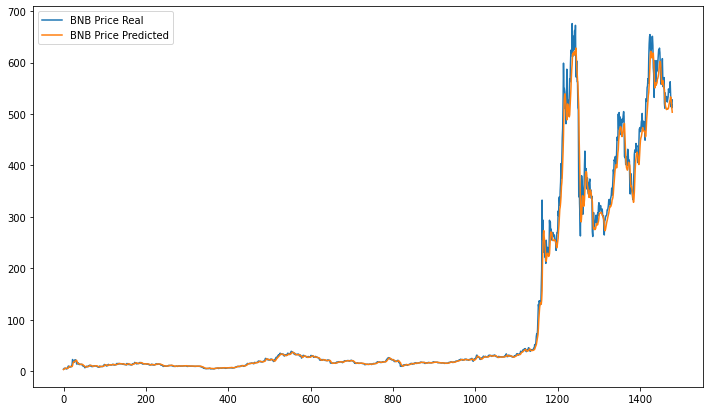

In [15]:
stocks = pd.DataFrame({
    'BNB Price Real': real_prices.ravel(),
    'BNB Price Predicted': predicted_prices.ravel()},
)
stocks.head()

stocks.plot(figsize=(12,7))